In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import coffee
from skimage.transform import resize as imresize
from scipy.misc import imsave
from scipy.ndimage import imread

In [2]:
## helper function to download from source URI
def download(path):
    from six.moves import urllib

    fname = path.split('/')[-1]
    if os.path.exists(fname):
        return fname

    print('Downloading ' + path)

    def progress(count, block_size, total_size):
        if count % 20 == 0:
            print('Downloaded %02.02f/%02.02f MB' % (
                count * block_size / 1024.0 / 1024.0,
                total_size / 1024.0 / 1024.0), end='\r')

    filepath, _ = urllib.request.urlretrieve(path, filename=fname, reporthook=progress)
    return filepath

In [3]:
##helper method to download vgg model
def get_vgg_model():
    download('https://s3.amazonaws.com/cadl/models/vgg16.tfmodel')
    with open("vgg16.tfmodel", mode='rb') as f:
        graph_def = tf.GraphDef()
        try:
            graph_def.ParseFromString(f.read())
        except:
            print('try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ' +
                  'to environment.  e.g.:\n' +
                  'PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython\n' +
                  'See here for info: ' +
                  'https://github.com/tensorflow/tensorflow/issues/582')

    download('https://s3.amazonaws.com/cadl/models/synset.txt')
    with open('synset.txt') as f:
        labels = [(idx, l.strip()) for idx, l in enumerate(f.readlines())]

    return {
        'graph_def': graph_def,
        'labels': labels,
        'preprocess': preprocess,
        'deprocess': deprocess
    }

In [4]:
##method to preprocess images
def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize, preserve_range=True)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)

##method to deprocess images
def deprocess(img):
    return np.clip(img * 255, 0, 255).astype(np.uint8)
    # return ((img / np.max(np.abs(img))) * 127.5 +
    #         127.5).astype(np.uint8)

In [5]:
def show_graph(graph_def):
    # Helper functions for TF Graph visualization
    def _strip_consts(graph_def, max_const_size=32):
        """Strip large constant values from graph_def."""
        strip_def = tf.GraphDef()
        for n0 in graph_def.node:
            n = strip_def.node.add()
            n.MergeFrom(n0)
            if n.op == 'Const':
                tensor = n.attr['value'].tensor
                size = len(tensor.tensor_content)
                if size > max_const_size:
                    tensor.tensor_content = "<stripped {} bytes>".format(size).encode()
        return strip_def

In [6]:
##download vgg model
net = get_vgg_model()

In [7]:
g = tf.Graph()
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tf.import_graph_def(net['graph_def'], name='vgg')
    names = [op.name for op in g.get_operations()]

In [8]:
for name in names:
    print(name)

vgg/images
vgg/mul/y
vgg/mul
vgg/split/split_dim
vgg/split
vgg/sub/y
vgg/sub
vgg/sub_1/y
vgg/sub_1
vgg/sub_2/y
vgg/sub_2
vgg/concat/concat_dim
vgg/concat
vgg/conv1_1/filter
vgg/conv1_1/Conv2D
vgg/conv1_1/biases
vgg/conv1_1/BiasAdd
vgg/conv1_1/conv1_1
vgg/conv1_2/filter
vgg/conv1_2/Conv2D
vgg/conv1_2/biases
vgg/conv1_2/BiasAdd
vgg/conv1_2/conv1_2
vgg/pool1
vgg/conv2_1/filter
vgg/conv2_1/Conv2D
vgg/conv2_1/biases
vgg/conv2_1/BiasAdd
vgg/conv2_1/conv2_1
vgg/conv2_2/filter
vgg/conv2_2/Conv2D
vgg/conv2_2/biases
vgg/conv2_2/BiasAdd
vgg/conv2_2/conv2_2
vgg/pool2
vgg/conv3_1/filter
vgg/conv3_1/Conv2D
vgg/conv3_1/biases
vgg/conv3_1/BiasAdd
vgg/conv3_1/conv3_1
vgg/conv3_2/filter
vgg/conv3_2/Conv2D
vgg/conv3_2/biases
vgg/conv3_2/BiasAdd
vgg/conv3_2/conv3_2
vgg/conv3_3/filter
vgg/conv3_3/Conv2D
vgg/conv3_3/biases
vgg/conv3_3/BiasAdd
vgg/conv3_3/conv3_3
vgg/pool3
vgg/conv4_1/filter
vgg/conv4_1/Conv2D
vgg/conv4_1/biases
vgg/conv4_1/BiasAdd
vgg/conv4_1/conv4_1
vgg/conv4_2/filter
vgg/conv4_2/Conv2D
vg

In [9]:
##Let's grab a placeholder for the input and output of the network:
x = g.get_tensor_by_name(names[0] + ':0') # tensorflow adds :0 to the name hence mentioning :0 is necessary
softmax = g.get_tensor_by_name(names[-2] + ':0')

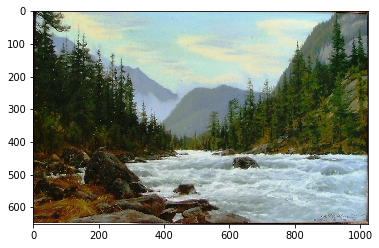

In [10]:
og = imread('content.jpg')
plt.imshow(og)
plt.show()

/home/pankaj/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


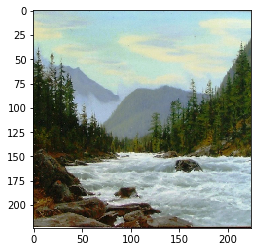

In [11]:
##preprocess the image into 224*224*3 tensor
img = preprocess(og)
plt.imshow(img)
plt.show()

In [12]:
##change the shape to a 4d tensor
img_4d = img[np.newaxis]
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = softmax.eval(feed_dict={x: img_4d,'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                       'vgg/dropout/random_uniform:0': [[1.0] * 4096]})#dropout keep =100%
    item=res[0].argmax()
    print("prob: ",res[0][item]," ",net['labels'][item])

prob:  0.997642   (979, 'n09468604 valley, vale')


### Defining the Content Features
For the "content" of the image, we're going to need to know what's happening in the image at the broadest spatial scale. Remember before when we talked about deeper layers having a wider receptive field? We're going to use that knowledge to say that the later layers are better at representing the overall content of the image. Let's try using the 4th layer's convolution for the determining the content:

In [13]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_layer = 'vgg/conv5_3/conv5_3:0'
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: img_4d,
                'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                'vgg/dropout/random_uniform:0': [[1.0] * 4096]
            })
print(content_features.shape)

(1, 14, 14, 512)


### Defining the Style Features
Great. We now have a tensor describing the content of our original image. We're going to stylize it now using another image. We'll need to grab another image.

/home/pankaj/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


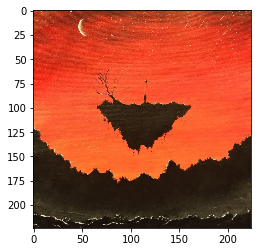

new image dim:  (1, 224, 224, 3)


In [14]:
style_og = plt.imread('style/style.jpg')
style_img = preprocess(style_og)
plt.imshow(style_img)
plt.show()
style_img_4d = style_img[np.newaxis]
print("new image dim: ",style_img_4d.shape)

In [15]:
##lets see what VGG thinks of it
img_4d = img[np.newaxis]
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = softmax.eval(feed_dict={x: style_img_4d,'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                       'vgg/dropout/random_uniform:0': [[1.0] * 4096]})#dropout keep =100%
    item=res[0].argmax()
    print("prob: ",res[0][item]," ",net['labels'][item])

prob:  0.480202   (611, 'n03598930 jigsaw puzzle')


In [16]:
##find features of this image at different layers in the network.
style_layers = ['vgg/conv1_1/conv1_1:0',
                'vgg/conv2_1/conv2_1:0',
                'vgg/conv3_1/conv3_1:0',
                'vgg/conv4_1/conv4_1:0',
                'vgg/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={
                x: style_img_4d,
                'vgg/dropout_1/random_uniform:0': [[1.0] * 4096],
                'vgg/dropout/random_uniform:0': [[1.0] * 4096]})
        style_activations.append(style_activation_i)

In [17]:
for i in range(len(style_activations)):
    print(i+1," : ",style_activations[i].shape)

1  :  (1, 224, 224, 64)
2  :  (1, 112, 112, 128)
3  :  (1, 56, 56, 256)
4  :  (1, 28, 28, 512)
5  :  (1, 14, 14, 512)


instead of using the raw activations of these layers, what the authors of the StyleNet paper suggest is to use the Gram activation of the layers instead, which mathematically is expressed as the matrix transpose multiplied by itself. The intuition behind this process is that it measures the similarity between every feature of a matrix. Or put another way, it is saying how often certain features appear together.
This would seem useful for "style", as what we're trying to do is see what's similar across the image. To get every feature, we're going to have to reshape our N x H x W x C matrix to have every pixel belonging to each feature in a single column. This way, when we take the transpose and multiply it against itself, we're measuring the shared direction of every feature with every other feature. Intuitively, this would be useful as a measure of style, since we're measuring whats in common across all pixels and features.

In [18]:
##to find out style features we have to calculate the ram matrices of each activation we calculated
style_features = []
for i, style_activation_i in enumerate(style_activations):
    print (i+1," style_activation: ",style_activation_i.shape)
    
    ## to measure the similarity between every feature of a matrix
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]]) 
    print (i+1," s_i: ",s_i.shape)
    print (" multiplying a ",s_i.T.shape," matix and ", s_i.shape, " matrix and deviding it by "
           , s_i.size, " to produce gram matrix")
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    print (i+1," gram_matrix: ",gram_matrix.shape)
    style_features.append(gram_matrix.astype(np.float32))
    print('')

1  style_activation:  (1, 224, 224, 64)
1  s_i:  (50176, 64)
 multiplying a  (64, 50176)  matix and  (50176, 64)  matrix and deviding it by  3211264  to produce gram matrix
1  gram_matrix:  (64, 64)

2  style_activation:  (1, 112, 112, 128)
2  s_i:  (12544, 128)
 multiplying a  (128, 12544)  matix and  (12544, 128)  matrix and deviding it by  1605632  to produce gram matrix
2  gram_matrix:  (128, 128)

3  style_activation:  (1, 56, 56, 256)
3  s_i:  (3136, 256)
 multiplying a  (256, 3136)  matix and  (3136, 256)  matrix and deviding it by  802816  to produce gram matrix
3  gram_matrix:  (256, 256)

4  style_activation:  (1, 28, 28, 512)
4  s_i:  (784, 512)
 multiplying a  (512, 784)  matix and  (784, 512)  matrix and deviding it by  401408  to produce gram matrix
4  gram_matrix:  (512, 512)

5  style_activation:  (1, 14, 14, 512)
5  s_i:  (196, 512)
 multiplying a  (512, 196)  matix and  (196, 512)  matrix and deviding it by  100352  to produce gram matrix
5  gram_matrix:  (512, 512)



### Remapping the Input
So now we have a collection of "features", which are basically the activations of our style image at different layers. We're now going to try and make our coffee image have the same style as this image by trying to enforce these features on the image. Let's take a look at how we can do that.
We're going to need to create a new graph which replaces the input of the original VGG network with a variable which can be optimized. So instead of having a placeholder as input to the network, we're going to tell tensorflow that we want this to be a tf.Variable. That's because we're going to try to optimize what this is, based on the objectives which we'll soon create.

In [19]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()
g = tf.Graph()

And now we'll load up the VGG network again, except unlike before, we're going to map the input of this network to a new variable randomly initialized to our content image. Alternatively, we could initialize this image noise to see a different result.

In [20]:
net = get_vgg_model()
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    ##net_input is the variable we map to the i/p placeholder of the network
    net_input = tf.Variable(img_4d)
    tf.import_graph_def(
        net['graph_def'],
        name='vgg',
        input_map={'images:0': net_input})

In [21]:
names = [op.name for op in g.get_operations()]
for name in names:
    print (name)

Variable/initial_value
Variable
Variable/Assign
Variable/read
vgg/images
vgg/mul/y
vgg/mul
vgg/split/split_dim
vgg/split
vgg/sub/y
vgg/sub
vgg/sub_1/y
vgg/sub_1
vgg/sub_2/y
vgg/sub_2
vgg/concat/concat_dim
vgg/concat
vgg/conv1_1/filter
vgg/conv1_1/Conv2D
vgg/conv1_1/biases
vgg/conv1_1/BiasAdd
vgg/conv1_1/conv1_1
vgg/conv1_2/filter
vgg/conv1_2/Conv2D
vgg/conv1_2/biases
vgg/conv1_2/BiasAdd
vgg/conv1_2/conv1_2
vgg/pool1
vgg/conv2_1/filter
vgg/conv2_1/Conv2D
vgg/conv2_1/biases
vgg/conv2_1/BiasAdd
vgg/conv2_1/conv2_1
vgg/conv2_2/filter
vgg/conv2_2/Conv2D
vgg/conv2_2/biases
vgg/conv2_2/BiasAdd
vgg/conv2_2/conv2_2
vgg/pool2
vgg/conv3_1/filter
vgg/conv3_1/Conv2D
vgg/conv3_1/biases
vgg/conv3_1/BiasAdd
vgg/conv3_1/conv3_1
vgg/conv3_2/filter
vgg/conv3_2/Conv2D
vgg/conv3_2/biases
vgg/conv3_2/BiasAdd
vgg/conv3_2/conv3_2
vgg/conv3_3/filter
vgg/conv3_3/Conv2D
vgg/conv3_3/biases
vgg/conv3_3/BiasAdd
vgg/conv3_3/conv3_3
vgg/pool3
vgg/conv4_1/filter
vgg/conv4_1/Conv2D
vgg/conv4_1/biases
vgg/conv4_1/BiasAd

So notice now the first layers of the network have everything prefixed by input, our new variable which we've just created. This will initialize a variable with the content image upon initialization. And then as we run whatever our optimizer ends up being, it will slowly become a stylized image.

### Defining the Content Loss
We now need to define a loss function which tries to optimize the distance between the net's output at our content layer, and the content features which we have built from the coffee image:

In [22]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

### Defining the Style Loss
For our style loss, we'll compute the gram matrix of the current network output, and then measure the l2 loss with our precomputed style image's gram matrix. So most of this is the same as when we compute the gram matrix for the style image, except now, we're doing this in tensorflow's computational graph, so that we can later connect these operations to an optimizer.

In [23]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        
        ##add the style loss from each style layer
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

### Defining the Total Variation Loss
Lastly, we'll create a third loss value which will simply measure the difference between neighboring pixels. By including this as a loss, we're saying that we want neighboring pixels to be similar.

In [24]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

## Training
With both content and style losses, we can combine the two, optimizing our loss function, and creating a stylized coffee cup.

In [25]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    loss = 0.1 * content_loss + 5.0 * style_loss + 0.01 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

0: 25.225674, (-0.009999 - 0.990000)


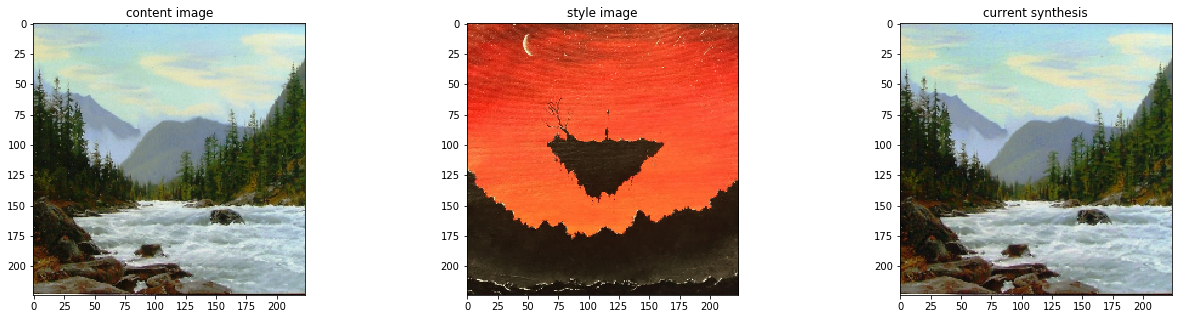

1: 23.444275, (-0.020004 - 0.989175)
2: 21.861519, (-0.029979 - 0.998211)
3: 20.465803, (-0.039891 - 1.006815)
4: 19.238132, (-0.049445 - 1.013978)
5: 18.149410, (-0.058672 - 1.015797)
6: 17.173834, (-0.067833 - 1.018162)
7: 16.290434, (-0.076839 - 1.024995)
8: 15.481085, (-0.085707 - 1.027769)
9: 14.733467, (-0.094481 - 1.034224)
10: 14.040741, (-0.103160 - 1.042482)


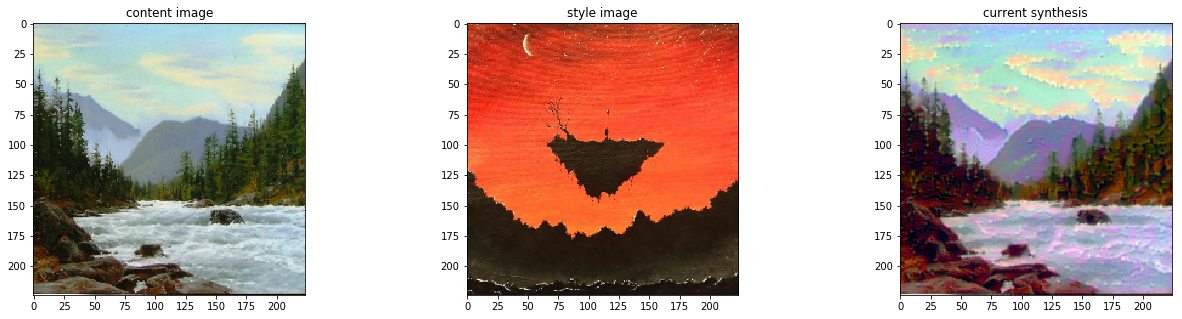

11: 13.398034, (-0.111770 - 1.050369)
12: 12.802788, (-0.120947 - 1.057966)
13: 12.253348, (-0.130196 - 1.065373)
14: 11.748035, (-0.139506 - 1.072589)
15: 11.284241, (-0.148881 - 1.079559)
16: 10.858455, (-0.158312 - 1.086225)
17: 10.467113, (-0.167762 - 1.092477)
18: 10.106812, (-0.177230 - 1.098320)
19: 9.774006, (-0.186727 - 1.103694)
20: 9.465639, (-0.196292 - 1.110849)


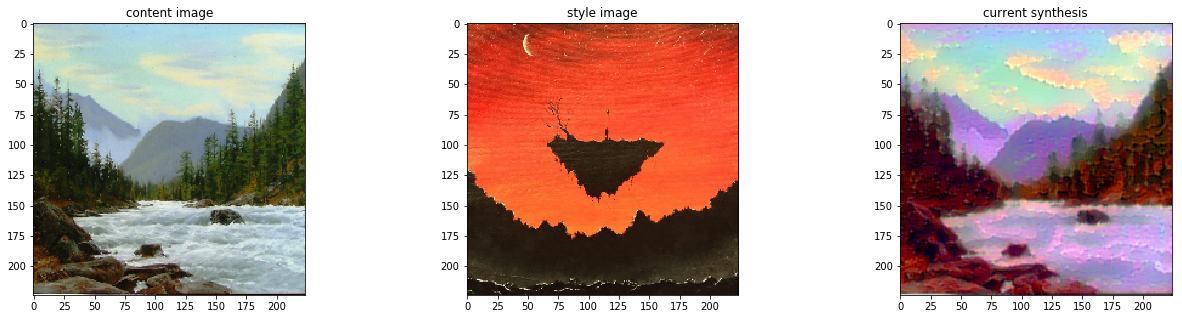

21: 9.178951, (-0.205948 - 1.120028)
22: 8.911613, (-0.215668 - 1.129213)
23: 8.660891, (-0.225478 - 1.138356)
24: 8.424282, (-0.235295 - 1.147481)
25: 8.199197, (-0.245095 - 1.156537)
26: 7.984094, (-0.254928 - 1.165475)
27: 7.777876, (-0.264769 - 1.174241)
28: 7.579503, (-0.274598 - 1.182817)
29: 7.388133, (-0.284481 - 1.191222)
30: 7.202759, (-0.294394 - 1.199407)


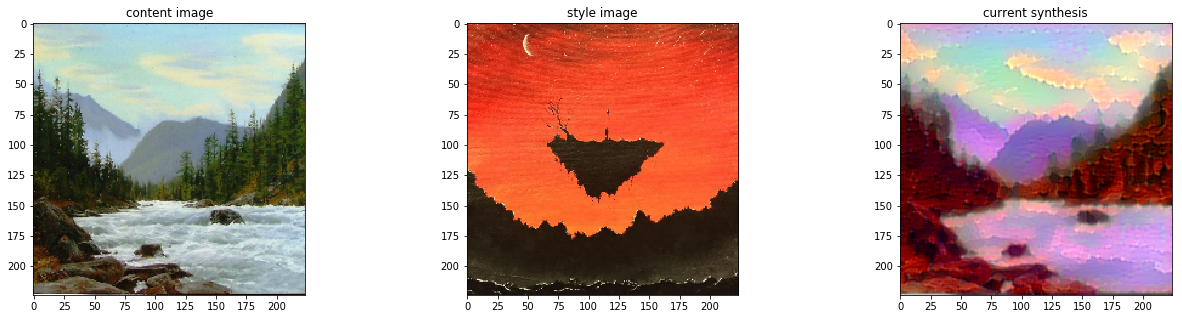

31: 7.022819, (-0.304313 - 1.207328)
32: 6.847890, (-0.314276 - 1.214960)
33: 6.677718, (-0.324244 - 1.222276)
34: 6.511906, (-0.334211 - 1.229291)
35: 6.350359, (-0.344214 - 1.235949)
36: 6.193053, (-0.354219 - 1.242236)
37: 6.039887, (-0.364237 - 1.248085)
38: 5.890811, (-0.374275 - 1.253861)
39: 5.745711, (-0.384296 - 1.260679)
40: 5.604426, (-0.394215 - 1.267042)


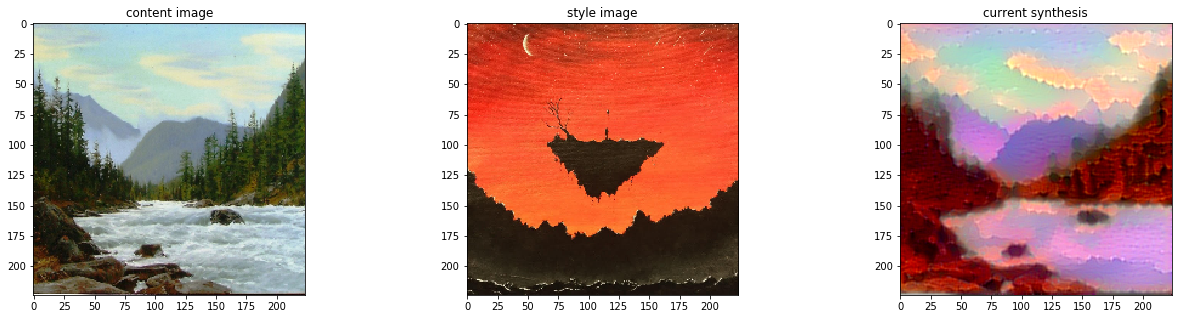

41: 5.466826, (-0.403984 - 1.272935)
42: 5.332801, (-0.413562 - 1.278367)
43: 5.202382, (-0.422940 - 1.283344)
44: 5.075349, (-0.432149 - 1.289890)
45: 4.951468, (-0.441187 - 1.296632)
46: 4.830708, (-0.449930 - 1.302916)
47: 4.713213, (-0.458303 - 1.308698)
48: 4.599014, (-0.466330 - 1.314065)
49: 4.488115, (-0.473964 - 1.318975)
50: 4.380512, (-0.481225 - 1.323387)


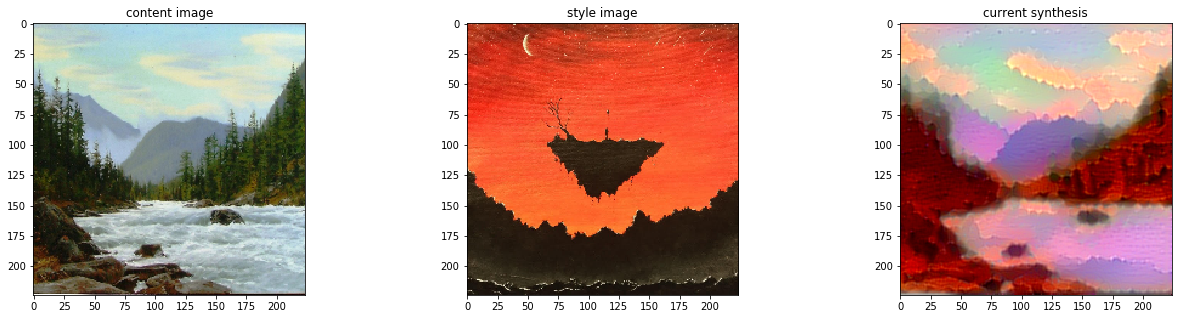

51: 4.275948, (-0.488117 - 1.327973)
52: 4.174380, (-0.494675 - 1.333354)
53: 4.075800, (-0.500912 - 1.338743)
54: 3.980113, (-0.506875 - 1.344189)
55: 3.887254, (-0.512596 - 1.349669)
56: 3.797415, (-0.517914 - 1.355165)
57: 3.710607, (-0.522710 - 1.360662)
58: 3.626952, (-0.526954 - 1.366081)
59: 3.546460, (-0.530739 - 1.371300)
60: 3.469102, (-0.534171 - 1.376210)


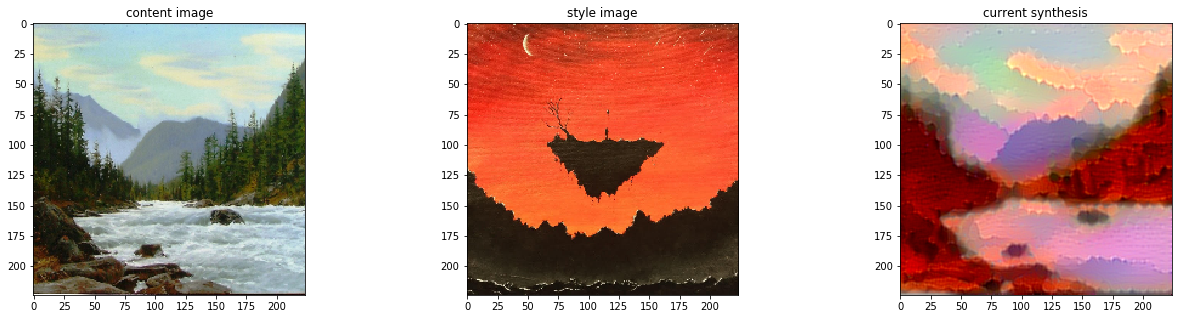

61: 3.394858, (-0.537384 - 1.380781)
62: 3.323665, (-0.540300 - 1.384988)
63: 3.255265, (-0.542936 - 1.388779)
64: 3.189675, (-0.545366 - 1.392193)
65: 3.126876, (-0.547534 - 1.395281)
66: 3.066773, (-0.549507 - 1.398101)
67: 3.009300, (-0.551258 - 1.400618)
68: 2.954227, (-0.552844 - 1.402901)
69: 2.901501, (-0.554230 - 1.404965)
70: 2.850963, (-0.555382 - 1.406852)


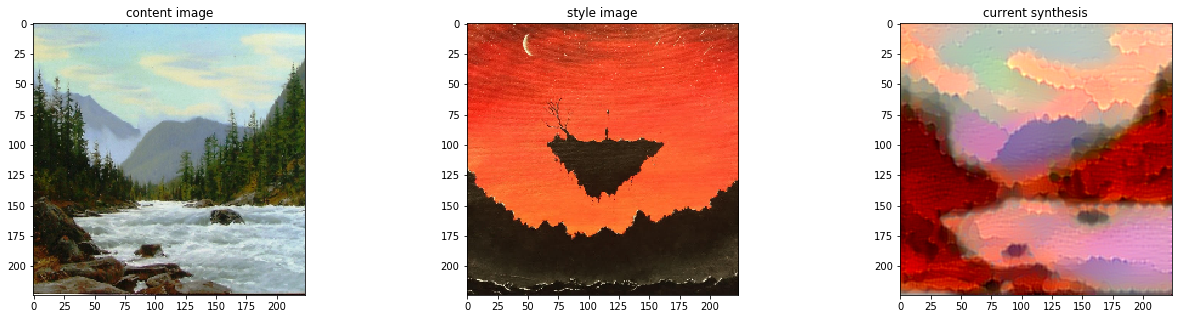

71: 2.802598, (-0.556306 - 1.409110)
72: 2.756208, (-0.557035 - 1.411369)
73: 2.711787, (-0.557536 - 1.413479)
74: 2.669260, (-0.557834 - 1.415479)
75: 2.628525, (-0.557847 - 1.417444)
76: 2.589476, (-0.557590 - 1.419288)
77: 2.552026, (-0.557107 - 1.421003)
78: 2.516084, (-0.556462 - 1.422527)
79: 2.481524, (-0.555821 - 1.423799)
80: 2.448274, (-0.555191 - 1.425475)


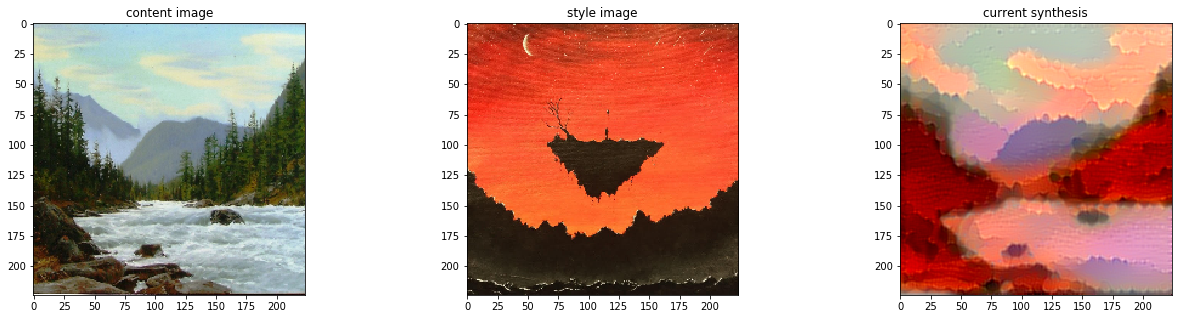

81: 2.416368, (-0.554634 - 1.427076)
82: 2.385782, (-0.554137 - 1.428569)
83: 2.356426, (-0.553646 - 1.429921)
84: 2.328164, (-0.553298 - 1.431167)
85: 2.300939, (-0.552999 - 1.432306)
86: 2.274813, (-0.552710 - 1.433280)
87: 2.249643, (-0.552384 - 1.434068)
88: 2.225378, (-0.551926 - 1.434718)
89: 2.202052, (-0.551288 - 1.435301)
90: 2.179616, (-0.550454 - 1.435814)


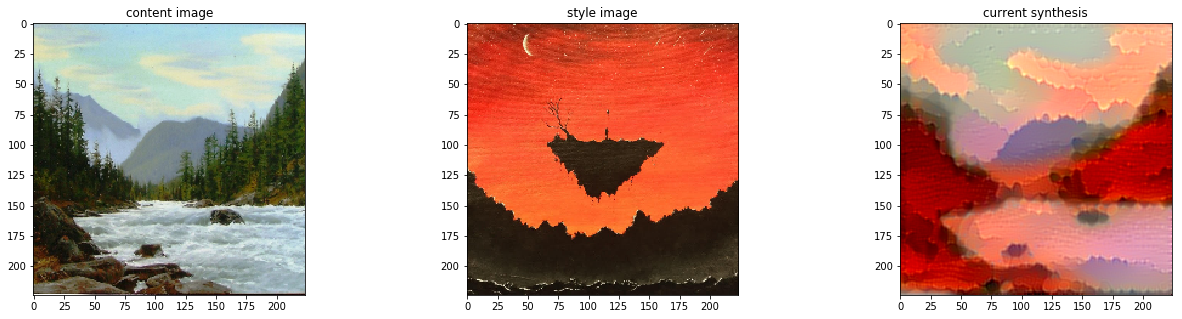

91: 2.157990, (-0.549434 - 1.436276)
92: 2.137089, (-0.548238 - 1.436688)
93: 2.116991, (-0.546827 - 1.437062)
94: 2.097653, (-0.545162 - 1.437375)
95: 2.079036, (-0.543224 - 1.437628)
96: 2.061098, (-0.541009 - 1.437821)
97: 2.043853, (-0.538565 - 1.437980)
98: 2.027250, (-0.536039 - 1.438099)
99: 2.011254, (-0.533488 - 1.438041)
100: 1.995822, (-0.530915 - 1.437853)


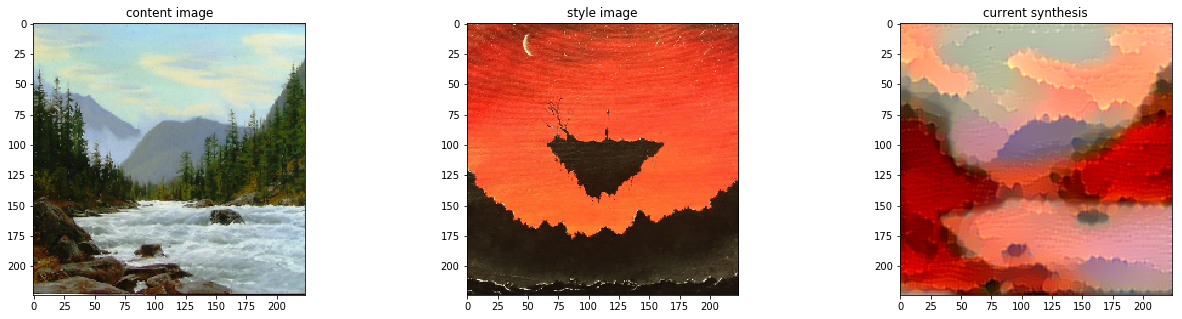

101: 1.980928, (-0.528358 - 1.437562)
102: 1.966521, (-0.525783 - 1.437152)
103: 1.952578, (-0.523182 - 1.436630)
104: 1.939112, (-0.520543 - 1.436004)
105: 1.926071, (-0.517910 - 1.435281)
106: 1.913454, (-0.515315 - 1.434478)
107: 1.901265, (-0.512765 - 1.433662)
108: 1.889452, (-0.510326 - 1.432840)
109: 1.877979, (-0.507932 - 1.432010)
110: 1.866852, (-0.505373 - 1.431179)


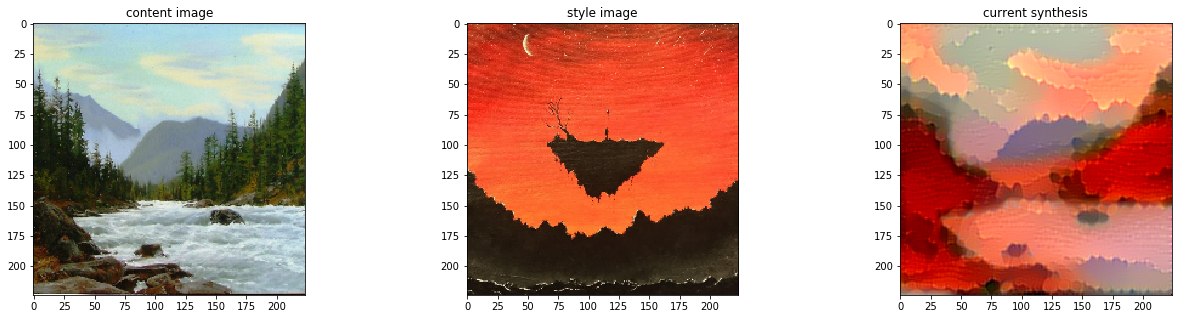

111: 1.856024, (-0.504344 - 1.430363)
112: 1.845480, (-0.503493 - 1.429540)
113: 1.835212, (-0.502600 - 1.428731)
114: 1.825244, (-0.501586 - 1.427930)
115: 1.815531, (-0.500524 - 1.427145)
116: 1.806095, (-0.499461 - 1.426405)
117: 1.796887, (-0.498438 - 1.425726)
118: 1.787965, (-0.497435 - 1.425092)
119: 1.779244, (-0.496446 - 1.424523)
120: 1.770753, (-0.495514 - 1.424043)


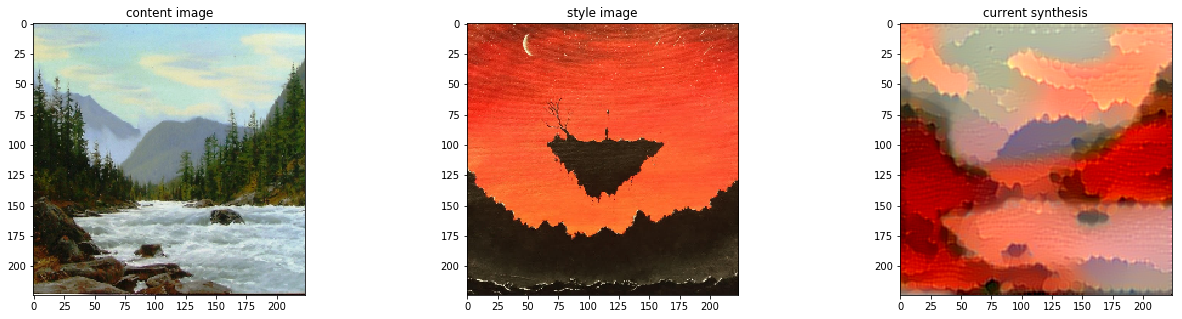

121: 1.762455, (-0.494698 - 1.423720)
122: 1.754336, (-0.494036 - 1.423465)
123: 1.746400, (-0.493531 - 1.423226)
124: 1.738679, (-0.493172 - 1.423090)
125: 1.731124, (-0.492979 - 1.423098)
126: 1.723769, (-0.492950 - 1.423210)
127: 1.716566, (-0.493074 - 1.423390)
128: 1.709515, (-0.493345 - 1.423429)
129: 1.702618, (-0.493732 - 1.423429)
130: 1.695880, (-0.494188 - 1.423189)


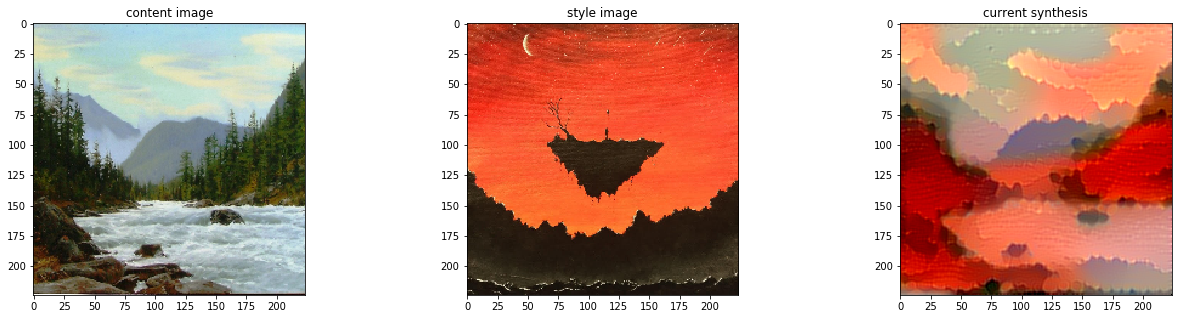

131: 1.689288, (-0.494667 - 1.422536)
132: 1.682837, (-0.495151 - 1.421821)
133: 1.676514, (-0.495620 - 1.421644)
134: 1.670325, (-0.496065 - 1.421472)
135: 1.664255, (-0.496167 - 1.421306)
136: 1.658291, (-0.495910 - 1.421140)
137: 1.652440, (-0.495599 - 1.420997)
138: 1.646695, (-0.495265 - 1.420858)
139: 1.641050, (-0.494867 - 1.420708)
140: 1.635514, (-0.494408 - 1.420542)


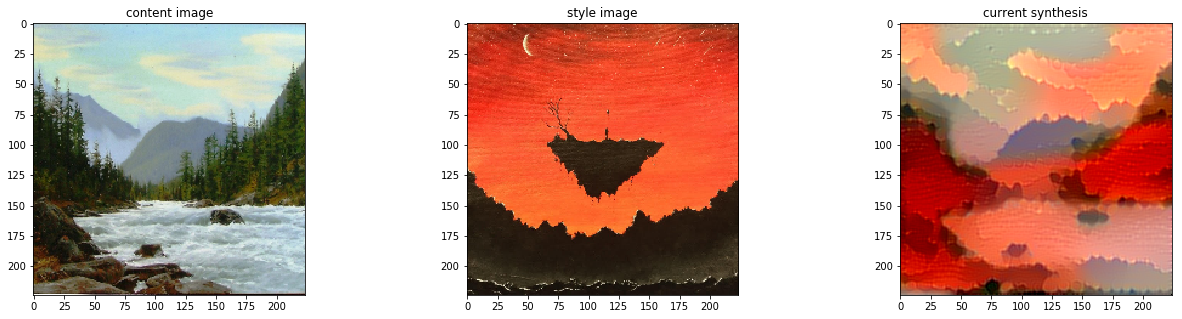

141: 1.630078, (-0.493906 - 1.420322)
142: 1.624783, (-0.493325 - 1.420020)
143: 1.619602, (-0.492386 - 1.419608)
144: 1.614507, (-0.491130 - 1.419094)
145: 1.609498, (-0.489902 - 1.418857)
146: 1.604569, (-0.488726 - 1.418807)
147: 1.599722, (-0.487706 - 1.419024)
148: 1.594986, (-0.486706 - 1.418940)
149: 1.590331, (-0.485714 - 1.418575)


In [26]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.global_variables_initializer())
    # map input to noise
    n_iterations = 150
    og_img = net_input.eval()
    imgs = []
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input],
                feed_dict={
                    'vgg/dropout_1/random_uniform:0':
                        np.ones(g.get_tensor_by_name(
                        'vgg/dropout_1/random_uniform:0').get_shape().as_list()),
                    'vgg/dropout/random_uniform:0':
                        np.ones(g.get_tensor_by_name(
                        'vgg/dropout/random_uniform:0').get_shape().as_list())})
        print("%d: %f, (%f - %f)" %
            (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 10 == 0:
            imgs.append(np.clip(synth[0], 0, 1))
            fig, ax = plt.subplots(1, 3, figsize=(22, 5))
            ax[0].imshow(deprocess(img))
            ax[0].set_title('content image')
            ax[1].imshow(deprocess(style_img))
            ax[1].set_title('style image')
            ax[2].set_title('current synthesis')
            ax[2].imshow(deprocess(synth[0]))
            plt.show()
            fig.canvas.draw()
    imsave('synth.png', imgs[-1])